# Probability Calculation
Calculate the probability by summing over the kde above the point.

H0 bootstrapping: Lx-T 8.7, 2.8sigma; Ysz-T 14.0, 4.1sigma

H0 mcmc: Lx-T 8.7, 2.4sigma; Ysz-T 14.0, 2.6sigma

In [1]:
# Read the data
import pandas as pd
data = pd.read_csv('/cosma/home/do012/dc-he4/anisotropy-flamingo/data/analysis_all/h0_direct_compare_scatter.csv')
data['Delta_H0'] *= 100    # Also brings delta_h0 to the order of magnitude of significance


In [2]:
data_joint = pd.merge(left=data[data['Relations']=='$L_\\mathrm{{X}}-T$'], 
                      right=data[data['Relations']=='$Y_\\mathrm{{SZ}}-T$'],
                      on='Lightcone', how='inner')
data_joint

,Relations_x,Delta_H0_x,Significance_x,Glon_x,Glat_x,Lightcone,Relations_y,Delta_H0_y,Significance_y,Glon_y,Glat_y
0,$L_\mathrm{{X}}-T$,7.385356,2.313296,-50.827893,13.043280,0,$Y_\mathrm{{SZ}}-T$,5.882586,1.343433,68.000000,-8.000000
1,$L_\mathrm{{X}}-T$,4.285675,0.819068,-92.000000,28.000000,1,$Y_\mathrm{{SZ}}-T$,11.058035,2.361757,108.000000,-8.000000
2,$L_\mathrm{{X}}-T$,6.973058,1.568688,123.220741,9.655936,2,$Y_\mathrm{{SZ}}-T$,6.304482,1.347089,-80.000000,-36.000000
3,$L_\mathrm{{X}}-T$,10.125532,2.136278,120.000000,-37.000000,3,$Y_\mathrm{{SZ}}-T$,8.572981,1.937059,4.000000,12.000000
4,$L_\mathrm{{X}}-T$,9.334221,2.057144,69.911098,-32.693093,4,$Y_\mathrm{{SZ}}-T$,8.378042,3.052702,96.000000,29.000000
...,...,...,...,...,...,...,...,...,...,...,...
1719,$L_\mathrm{{X}}-T$,5.578047,1.507787,132.000000,74.000000,1723,$Y_\mathrm{{SZ}}-T$,8.249033,2.313997,-8.000000,2.000000
1720,$L_\mathrm{{X}}-T$,5.610250,1.637693,-110.728583,-10.545291,1724,$Y_\mathrm{{SZ}}-T$,6.574890,2.730992,72.000000,56.000000
1721,$L_\mathrm{{X}}-T$,10.330527,3.566578,71.665508,47.663220,1725,$Y_\mathrm{{SZ}}-T$,8.320368,1.877766,20.000000,16.000000
1722,$L_\mathrm{{X}}-T$,9.431441,2.413894,24.000000,54.000000,1726,$Y_\mathrm{{SZ}}-T$,10.060892,2.831550,-124.000000,34.000000


In [3]:
# Calculate the angular correlation
import sys
sys.path.append('/cosma/home/do012/dc-he4/anisotropy-flamingo/tools')
import clusterfit as cf

# coordinates
xlon = data_joint['Glon_x'].values
xlat = data_joint['Glat_x'].values
ylon = data_joint['Glon_y'].values
ylat = data_joint['Glon_y'].values

# calculate angular separation
theta = cf.angular_separation(xlon, xlat, ylon, ylat)

/cosma/home/do012/dc-he4/.conda/envs/halo-cosma/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


We make a five variate kde at M21 point. theta=9.125

In [4]:
cf.angular_separation(274, -9, 268, -16)

9.124859791423663

In [5]:
# Add angular separation to the data set
data_joint['Theta'] = theta

In [6]:
# kde estimation
import scipy.stats as stats
import numpy as np

# Gaussian kde estimation
dataset = data_joint[['Delta_H0_x', 'Delta_H0_y', 'Significance_x', 'Significance_y', 'Theta']]
kde = stats.gaussian_kde(dataset.T.values)

## Method 1, KDE estimation
Five parameter estimation, doesn't converge.

In [ ]:

# Create grid points (5D so cannot be too dense)
a_grid = np.linspace(0, 30, 100)
b_grid = np.linspace(0, 30, 100)
c_grid = np.linspace(0, 10, 100)
d_grid = np.linspace(0, 10, 100)
e_grid = np.linspace(0, 50, 100)
A, B, C, D, E = np.meshgrid(a_grid, b_grid, c_grid, d_grid, e_grid)
positions = np.vstack([A.ravel(), B.ravel(), C.ravel(), D.ravel(), E.ravel()])
Z = kde(positions).reshape(A.shape)
print(Z.shape)

In [11]:
# Sum up the probability mass
point = np.array([8.7, 14, 2.8, 4.1, 9.125])
dx = (a_grid[1]-a_grid[0])\
    * (b_grid[1] - b_grid[0])\
    * (c_grid[1] - c_grid[0])\
    * (d_grid[1] - d_grid[0])\
    * (e_grid[1] - e_grid[0])
prob = kde(point) * dx
prob_mass = Z * dx
prob_above = np.sum(prob_mass[prob_mass > prob])
prob_below = np.sum(prob_mass[prob_mass < prob])
print('total integral (should be 1)', np.sum(prob_mass))
print(prob_above, prob_below)
print(1-prob_above)
# print(np.sqrt(-2*np.log(1-prob_above)))

0.16572765120917504
0.16568214555749206
p-value 0.834317854442508


## Method 2, EVT estimation

In [7]:

import numpy as np
import pandas as pd
from scipy.stats import genpareto
import matplotlib.pyplot as plt
from scipy.special import erfinv
import math
plt.style.use('./nice.mplstyle')


def load_data(file_path, data_type='mc'):
    data = pd.read_csv(file_path)
    if data_type == 'direct_compare':
        data['Delta_H0'] *= 100
    return data

def extract_data(data, relation):
    df = data[data['Relations'] == relation]
    if 'Delta_H0' in df.columns:
        delta_h0 = df['Delta_H0'].values
    else:
        delta_h0 = df['$\Delta H_0\,(\%)$'].values
    if 'Significance $(\sigma)$' in df.columns:
        significance = df['Significance $(\sigma)$'].values
    else:
        significance = df['Significance'].values
    return delta_h0, significance

def calculate_sigma_p_value(delta_h0_proj, target_value):
    median = np.median(delta_h0_proj)
    sigma_84th = np.percentile(delta_h0_proj, 84)
    sigma = sigma_84th - median
    sigma_deviation = np.abs((target_value - median) / sigma)
    p_value_sigma = 1 - math.erf(sigma_deviation / np.sqrt(2))
    return sigma_deviation, p_value_sigma

def calculate_evt_p_value(delta_h0_proj, target_value, fix_shape=0.5, percentile=90):
    # Determine the threshold
    threshold = np.percentile(delta_h0_proj, percentile)
    exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold  # Tail data

    # Fit GPD to the tail data
    if fix_shape is not None:
        params = genpareto.fit(exceedances, f0=fix_shape)
    else:
        params = genpareto.fit(exceedances)
    shape, loc, scale = params
    print(shape, loc, scale)

    # Tail survival probability (proportion of data in the tail)
    tail_prob = np.sum(delta_h0_proj >= threshold) / len(delta_h0_proj)

    if target_value > threshold:
        # Conditional probability adjusted to match at the threshold
        p_value_evt = (1 - genpareto.cdf(target_value - threshold, *params)) * tail_prob
        # print(genpareto.cdf(target_value - threshold, *params))
    else:
        # Empirical CDF for the bulk region
        p_value_evt = np.sum(delta_h0_proj >= target_value) / len(delta_h0_proj)

    # Transform to sigma (Gaussian equivalent deviation)
    sigma_deviation = np.sqrt(2) * erfinv(1 - p_value_evt)

    return p_value_evt, sigma_deviation

# The first projection function
def default_proj(delta_H0, n_sigma):
    return delta_H0 - delta_H0 / n_sigma

In [8]:
# Remove problematic lightcone 1318
print(len(data_joint))

1724


Sigma deviation: 3.43σ, p-value: 0.000594
-0.0645708627549546 0.0036757449865355346 0.8432455292938165
Probability of target value: 0.00118, (3.24sigma)


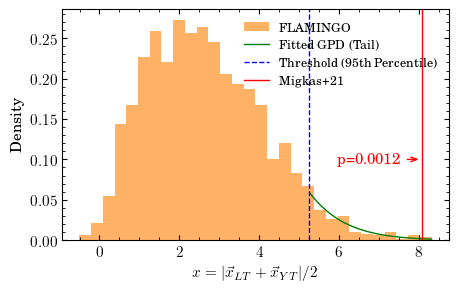

In [12]:
def proj_average_vector(delta_h0_x, n_sigma_x, delta_h0_y, n_sigma_y, theta):
    """ vec{z} = (vec{x} + vec{y})/2
        The projected value is |vec{z}| = 1/2 (xcos(theta/2) + ycos(theta/2))
    """
    theta = theta * np.pi / 180  # convert angle to radian
    return 1/2 * (default_proj(delta_h0_x, n_sigma_x) * np.cos(theta/2) + 
                  default_proj(delta_h0_y, n_sigma_y) * np.cos(theta/2))

def proj_average_scalar(delta_h0_x, n_sigma_x, delta_h0_y, n_sigma_y):
    return 1/2 * (default_proj(delta_h0_x, n_sigma_x)
                  + default_proj(delta_h0_y, n_sigma_y))

delta_h0_proj = proj_average_vector(
    delta_h0_x=data_joint['Delta_H0_x'].values,
    n_sigma_x=data_joint['Significance_x'].values,
    delta_h0_y=data_joint['Delta_H0_y'].values,
    n_sigma_y=data_joint['Significance_y'].values,
    theta=data_joint['Theta'].values   # input angle in degree, will convert to radian before computation
)

# Single combine value
# target_value = default_proj(delta_H0=9, n_sigma=5.4)

# Project target value
target_value = proj_average_vector(8.7, 2.8, 14, 4.1, theta=9)

# The number of sigma deviation
sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")

# Select percentile here
percentile = 95
fix_shape = None
p_value_evt, sigma_evt = calculate_evt_p_value(delta_h0_proj, target_value, fix_shape, percentile)
print(f"Probability of target value: {p_value_evt:.3g}, ({sigma_evt:.3g}sigma)")

# Make fit
threshold = np.percentile(delta_h0_proj, percentile)
exceedances = delta_h0_proj[delta_h0_proj > threshold] - threshold
if fix_shape is not None:
    params = genpareto.fit(exceedances, f0=fix_shape)
else:
    params = genpareto.fit(exceedances)
shape, loc, scale = params

# Plotting results
plt.figure(figsize=(5, 3))
plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='#ff7f00', label='FLAMINGO')
x_vals = np.linspace(threshold, delta_h0_proj.max(), 100)
gpd_pdf = genpareto.pdf(x_vals - threshold, shape, loc, scale) * (1 - percentile / 100)
plt.plot(x_vals[1:], gpd_pdf[1:], color='g', label='Fitted GPD (Tail)')
plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({percentile}th Percentile)')
plt.axvline(target_value, color='red', linestyle='-', label=f'Migkas+21')

# Annotate the plot
plt.annotate(f'p={p_value_evt:.2g}', 
         xy=(target_value, 0.1), xycoords='data',
         xytext=(target_value - 0.5, 0.1), textcoords='data',
         arrowprops=dict(arrowstyle='->,head_width=.15', color='red'),
         horizontalalignment='right', verticalalignment='center', color='red')

plt.xlabel(r'$x = |\vec{x}_{LT} + \vec{x}_{YT}| / 2$')
plt.ylabel('Density')
plt.legend(fontsize=9)

# plt.savefig('./to_paper/evs_joint_m21_scatter.pdf', bbox_inches='tight')
plt.show()

In [12]:
target_value = proj_average_vector(delta_h0_x=8.7, delta_h0_y=14.0, n_sigma_x=2.8, n_sigma_y=4.1, theta=9)
print(target_value)

target_value = default_proj(delta_H0=9.0, n_sigma=5.4)
print(target_value)

8.064175467113193
7.333333333333334


## Generalized extreme value
fit scipy.stats.genextreme for all

Sigma deviation: 2.98σ, p-value: 0.00285
Probability of target value: 0.00508, (2.8sigma)


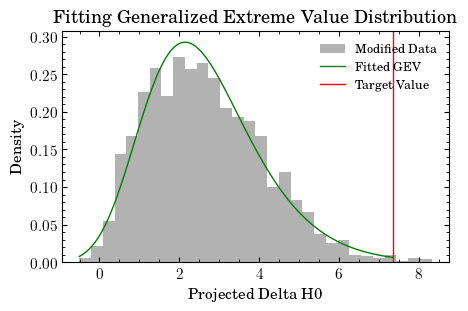

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import genextreme
import matplotlib.pyplot as plt
from scipy.special import erfinv
import math

def load_data(file_path, data_type='mc'):
    data = pd.read_csv(file_path)
    if data_type == 'direct_compare':
        data['Delta_H0'] *= 100
    return data

def extract_data(data, relation):
    df = data[data['Relations'] == relation]
    if 'Delta_H0' in df.columns:
        delta_h0 = df['Delta_H0'].values
    else:
        delta_h0 = df['$\\Delta H_0\\,(\\%)$'].values
    if 'Significance $(\\sigma)$' in df.columns:
        significance = df['Significance $(\\sigma)$'].values
    else:
        significance = df['Significance'].values
    return delta_h0, significance

def calculate_sigma_p_value(delta_h0_proj, target_value):
    median = np.median(delta_h0_proj)
    sigma_84th = np.percentile(delta_h0_proj, 84)
    sigma = sigma_84th - median
    sigma_deviation = np.abs((target_value - median) / sigma)
    p_value_sigma = 1 - math.erf(sigma_deviation / np.sqrt(2))
    return sigma_deviation, p_value_sigma

def calculate_gev_p_value(delta_h0_proj, target_value):
    # Fit GEV to the data
    params = genextreme.fit(delta_h0_proj)
    shape, loc, scale = params

    # Calculate the p-value using the CDF of the fitted GEV distribution
    p_value_gev = 1 - genextreme.cdf(target_value, *params)

    # Transform to sigma (Gaussian equivalent deviation)
    sigma_deviation = np.sqrt(2) * erfinv(1 - p_value_gev)

    return p_value_gev, sigma_deviation

# The first projection function
def default_proj(delta_H0, n_sigma):
    return delta_H0 - delta_H0 / n_sigma

def proj_average_vector(delta_h0_x, n_sigma_x, delta_h0_y, n_sigma_y, theta):
    """ vec{z} = (vec{x} + vec{y})/2
        The projected value is |vec{z}| = 1/2 (xcos(theta/2) + ycos(theta/2))
    """
    theta = theta * np.pi / 180  # convert angle to radian
    return 1/2 * ((delta_h0_x - delta_h0_x/n_sigma_x) * np.cos(theta/2) + 
                  (delta_h0_y - delta_h0_y/n_sigma_y) * np.cos(theta/2))

delta_h0_proj = proj_average_vector(
    delta_h0_x=data_joint['Delta_H0_x'].values,
    n_sigma_x=data_joint['Significance_x'].values,
    delta_h0_y=data_joint['Delta_H0_y'].values,
    n_sigma_y=data_joint['Significance_y'].values,
    theta=data_joint['Theta'].values   # input angle in degree, will convert to radian before computation
)

target_value = default_proj(delta_H0=9.0, n_sigma=5.4)

sigma_deviation, p_value_sigma = calculate_sigma_p_value(delta_h0_proj, target_value)
print(f"Sigma deviation: {sigma_deviation:.3g}σ, p-value: {p_value_sigma:.3g}")

p_value_gev, sigma_gev = calculate_gev_p_value(delta_h0_proj, target_value)
print(f"Probability of target value: {p_value_gev:.3g}, ({sigma_gev:.3g}sigma)")

# Plotting results
params = genextreme.fit(delta_h0_proj)
shape, loc, scale = params

plt.figure(figsize=(5, 3))
plt.hist(delta_h0_proj, bins=30, density=True, alpha=0.6, color='gray', label='Modified Data')
x_vals = np.linspace(delta_h0_proj.min(), target_value, 100)
gev_pdf = genextreme.pdf(x_vals, shape, loc, scale)
plt.plot(x_vals, gev_pdf, color='g', label='Fitted GEV')
plt.axvline(target_value, color='red', linestyle='-', label='Target Value')
plt.xlabel('Projected Delta H0')
plt.ylabel('Density')
plt.legend(fontsize=9)
plt.title('Fitting Generalized Extreme Value Distribution')
plt.show()